https://github.com/acpedersen/Project-4-Physics-Gym

In [1]:
!pip install gym
!pip install imageio-ffmpeg
!pip install tf-agents

In [2]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [38]:
env_name = 'Acrobot-v1'
env = suite_gym.load(env_name)

In [39]:
env.reset()

TimeStep(step_type=array(0), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.9972274 , -0.07441458,  0.9958519 ,  0.09098903,  0.00659076,
       -0.07896887], dtype=float32))

In [40]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)
env.close()

Time step:
TimeStep(step_type=array(0), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.9967359 , -0.08073142,  0.9999509 , -0.00991159,  0.05095242,
        0.02392745], dtype=float32))
Next time step:
TimeStep(step_type=array(1), reward=array(-1., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.99811566, -0.0613605 ,  0.9999353 , -0.01137461,  0.13917738,
       -0.03517035], dtype=float32))


In [41]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [42]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [43]:
fc_layer_params = (100,)

actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [44]:
learning_rate = 1e-3
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)

agent.initialize()

In [45]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [46]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        
        total_return += episode_return
    
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [47]:
replay_buffer_capacity = 2000
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [48]:
agent.collect_data_spec

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(6,), dtype=tf.float32, name='observation', minimum=array([ -1.      ,  -1.      ,  -1.      ,  -1.      , -12.566371,
       -28.274334], dtype=float32), maximum=array([ 1.      ,  1.      ,  1.      ,  1.      , 12.566371, 28.274334],
      dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0, dtype=int64), maximum=array(2, dtype=int64)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [49]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [50]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [51]:
#Rework to record the training as a video clip
def collect_episode(environment, policy, num_episodes, rendering_enviroment = None, video=None):

    episode_counter = 0
    environment.reset()
    if video != None:
        video.append_data(rendering_enviroment.render())
    while episode_counter < num_episodes:
        time_step = environment.current_time_step()
        action_step = policy.action(time_step)
        
        if video != None:
            video.append_data(rendering_enviroment.render())
        
        next_time_step = environment.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)

        # Add trajectory to the replay buffer
        replay_buffer.add_batch(traj)

        if traj.is_boundary():
            episode_counter += 1
            #Little hack to only record the first episode
            video=None
    

In [52]:
#Changed to have individual episodes be seperate to make the model be quicker in reaching the goal
#Could not get to work and is unused
def collect_long_episode(environment, policy, episode_steps):
    step_counter = 0

    observations, actions, infos, rewards, discounts = [], [], [], [], []
    
    environment.reset()
    while step_counter < episode_steps:
        time_step = environment.current_time_step()
        observations.append(time_step.observation)
        
        action_step = policy.action(time_step)
        infos.append(action_step.info)
        actions.append(action_step.action)
        
        next_time_step = environment.step(action_step.action)
        rewards.append(next_time_step.reward)
        discounts.append(next_time_step.discount)
        step_counter+=1
    
    #return  observations, actions, infos, rewards, discounts
    
    # Create and add trajectory to the replay buffer
    traj = trajectory.from_episode(tuple(observations), tuple(actions), tuple(infos), tuple(rewards))#, tuple(discounts))
    return traj
    #replay_buffer.add_batch(traj)

In [53]:
num_iterations = 300
collect_episodes_per_iteration = 2
num_eval_episodes = 10
log_interval = 25
eval_interval = 50

record_interval = 30

In [54]:
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

replay_buffer.clear()

trainingFilename = "training-agent.mp4"

step = 0
with imageio.get_writer(trainingFilename, fps=60) as trainingVideo:
    for _ in range(num_iterations):

        if step % record_interval == 0:
            collect_episode(train_env, agent.collect_policy, collect_episodes_per_iteration, train_py_env, trainingVideo)
        else:
            collect_episode(train_env, agent.collect_policy, collect_episodes_per_iteration)
        # Use data from the buffer and update the agent's network.
        experience = replay_buffer.gather_all()

        train_loss = agent.train(experience)
        replay_buffer.clear()

        step = agent.train_step_counter.numpy()

        if step % log_interval == 0:
            print('step = {0}: loss = {1}'.format(step, train_loss.loss))

        if step % eval_interval == 0:
            avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
            print('step = {0}: Average Return = {1}'.format(step, avg_return))
            returns.append(avg_return)

    train_env.close()
    eval_env.close()
    train_py_env.close()
    eval_py_env.close()
    
embed_mp4(trainingFilename)

step = 25: loss = -0.14219504594802856
step = 50: loss = -0.9886243343353271
step = 50: Average Return = -143.39999389648438
step = 75: loss = -7.817002296447754
step = 100: loss = -36.87751770019531
step = 100: Average Return = -290.0
step = 125: loss = -17.846330642700195
step = 150: loss = -12.06595230102539
step = 150: Average Return = -97.5
step = 175: loss = -26.614715576171875
step = 200: loss = -11.662059783935547
step = 200: Average Return = -108.80000305175781
step = 225: loss = -12.31270980834961
step = 250: loss = -15.201326370239258
step = 250: Average Return = -170.5
step = 275: loss = -23.456737518310547
step = 300: loss = -18.454875946044922
step = 300: Average Return = -89.0999984741211


(-520.545000076294, 10)

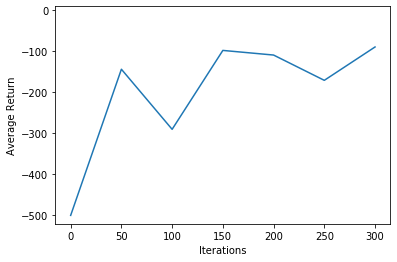

In [55]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=10)

In [56]:
def create_policy_eval_video(policy, filename, num_episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())
    
    eval_py_env.close()
    
    return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")